# Loading the environement and importing the packages

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd ../gdrive/My\ Drive/coil20

/gdrive/My Drive/coil20


In [0]:
# load image and convert to and from NumPy array
from PIL import Image
from numpy import asarray
import numpy as np
from sklearn.decomposition import PCA
import scipy
import math 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from numpy.linalg import multi_dot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import scipy.io
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Some helper functions

In [0]:
def loss_perso(X,Q,Z,S,Qg,Beta=0.1):
    return np.linalg.norm(X2-multi_dot([X2,Q,np.transpose(Q)]))+np.linalg.norm(np.dot(X2,Q)-np.dot(Z,S))-2*Beta*np.trace(multi_dot([np.transpose(Z),B,np.transpose(Qg)]))

In [0]:
def algo1_init(X2,q,g):
  # Get top 16 PCA components
  q=20
  pca = PCA(n_components=q)
  principalComponents = pca.fit_transform(X2)
  X_reconst=pca.inverse_transform(principalComponents)
  print("loss = ")
  print(((X2 - X_reconst) ** 2).mean())
  print("explained variance ratio ")
  pca.explained_variance_ratio_

  Q=np.transpose(pca.components_)
  #create similarity matrix 
  W=np.zeros(shape=(X2.shape[0],X2.shape[0]))
  for i in range(0,W.shape[0]):
      for j in range(0,W.shape[0]):
          W[i][j]=math.sqrt(np.dot(X2[i], X2[i]) - 2 * np.dot(X2[i], X2[j]) + np.dot(X2[j], X2[j]))
  W=1-np.exp(-W/np.mean(W))
  #np.save('weight_Coil20.npy', W)
  #W=np.load('weight_Coil20.npy')
  #create degree matrix 
  D=np.zeros(shape=(W.shape[0],W.shape[1]))
  for i in range(0,W.shape[0]):
      D[i][i]=np.sum(W[:,i])
  #create laplacian matrix
  L=D-W
  B, delta, B_t = np.linalg.svd(L, full_matrices=True)
  #Create S using XQ
  #each object has 72 pictures
  S=np.zeros(shape=(g,q))
  XQ=np.dot(X2,Q)
  kmeans = KMeans(n_clusters=g, random_state=0,init='k-means++',n_init=10, max_iter=300).fit(XQ)
  S=kmeans.cluster_centers_
  #evaluate clusters quality
  nmi=normalized_mutual_info_score(true_label,kmeans.labels_)
  ari=adjusted_rand_score(true_label,kmeans.labels_)
  print(nmi)
  print(ari)
  #create Z
  Z=np.zeros(shape=(n,g))
  for i in range(0,n):
      Z[i][kmeans.labels_[i]]=1
  #compute QG (initialization)
  Ug, D1g, Vg = np.linalg.svd(np.dot(np.transpose(Z),B), full_matrices=True)
  sigma=np.zeros(shape=(np.dot(np.transpose(Z),B).shape[0],np.dot(np.transpose(Z),B).shape[1]))
  for i in range(0,len(D1g)):
      sigma[i][i]=D1g[i]
  Qg=multi_dot([Ug, sigma,Vg])
  return S,Q,Qg,Z,B

In [0]:
def algo1_clustering(S,Z,Q,Qg,X2,B,Beta):
  loss_cur=200
  loss_pred=100
  while(loss_cur-loss_pred>0.1):
    loss_pred=loss_cur
    #compute S
    S=multi_dot([np.linalg.inv(np.dot(np.transpose(Z),Z)),np.transpose(Z),X2,Q])

    #compute Z
    #we find for each sample which center is the nearest
    Z1=np.zeros(shape=(n,g))
    pred_label=[]
    XQ=np.dot(X2,Q)
    for i in range(0,n):
      minimum=0
      val_min=np.linalg.norm(XQ[i]-S[0])
      for k in range(1,g):
        val=np.linalg.norm(XQ[i]-S[k])-2*Beta*np.dot(B,np.transpose(Qg))[i][k]
        if(val<val_min):
          val_min=val
          minimum=k
      Z1[i][minimum]=1
      pred_label.append(minimum)

    #Compute Q 
    U, D1, V = np.linalg.svd(multi_dot([np.transpose(X2),Z,S]), full_matrices=True)
    sigma=np.zeros(shape=(Q.shape[0],Q.shape[1]))
    for i in range(0,len(D1)):
        sigma[i][i]=1
    Q=multi_dot([U, sigma,V])

    #compute QG
    Ug, D1g, Vg = np.linalg.svd(np.dot(np.transpose(Z),B), full_matrices=True)
    sigma=np.zeros(shape=(np.dot(np.transpose(Z),B).shape[0],np.dot(np.transpose(Z),B).shape[1]))
    for i in range(0,len(D1g)):
        sigma[i][i]=1
    Qg=multi_dot([Ug, sigma,Vg])
    nmi=normalized_mutual_info_score(true_label,pred_label)
    ari=adjusted_rand_score(true_label,pred_label)
    print("nmi = ",nmi)
    print("ari = ",ari)
    loss_cur=loss_perso(X2,Q,Z,S,Qg,Beta)
    print("loss = ",loss_cur)
    print("davies bouldin score = ",davies_bouldin_score(X2, pred_label)) 
    print("Silhouette score = ",silhouette_score(X2, pred_label)) 
  Y=np.dot(X2,Q)
  return Y

In [0]:
def algo1_visualization(Y):
  fig = plt.figure(figsize=(30, 18))
  ax = fig.add_subplot(251)
  ax.scatter(Y[:,0], Y[:,1], c=true_label, cmap=plt.cm.Spectral)
  plt.title("Algo one projection" )

# COIL20 DATASET

Text(0.5, 1.0, "Cumulative Variable's Exlained Variance")

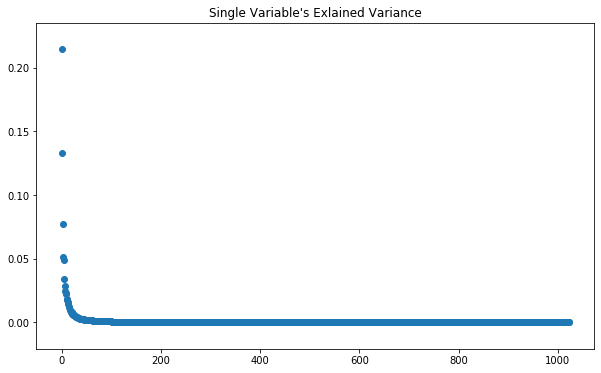

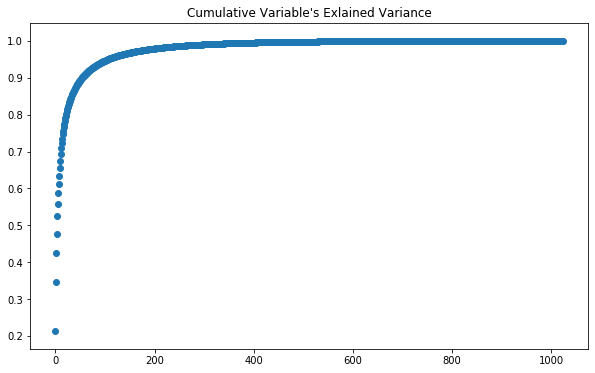

In [0]:
mat = scipy.io.loadmat('COIL20.mat')
X2=mat['fea']
true_label=mat['gnd'].flatten()
n=X2.shape[0]
#X2 = StandardScaler().fit_transform(X2)
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
q=min(X2.shape[0],X2.shape[1])
pca = PCA(n_components=q)
principalComponents = pca.fit_transform(X2)

#on peut prendre q=15 0.75% de la variance expliquer et remarque que au dela on ne gagne pas grand chose on ajoutant des composantes

plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_)
plt.title("Single Variable's Exlained Variance")
plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Variable's Exlained Variance")

In [0]:
g=20
q=20
S,Q,Qg,Z,B=algo1_init(X2,q,g)

loss = 
0.2179187462458238
explained variance ratio 
0.7919916836960884
0.6208489031478768


In [0]:
Y=algo1_clustering(S,Z,Q,Qg,X2,B,0.4)

nmi =  0.7919916836960884
ari =  0.6208489031478768
loss =  940.0392022743756
davies bouldin score =  1.7420001132150975
Silhouette score =  0.21905762497298195
nmi =  0.7928213850176038
ari =  0.6212043820187029
loss =  934.3901426202103
davies bouldin score =  1.7428009900617922
Silhouette score =  0.21899793618116273


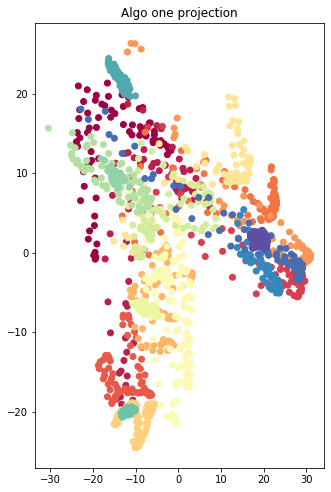

In [0]:
algo1_visualization(Y)

# COIL100 DATASET

Text(0.5, 1.0, "Cumulative Variable's Exlained Variance")

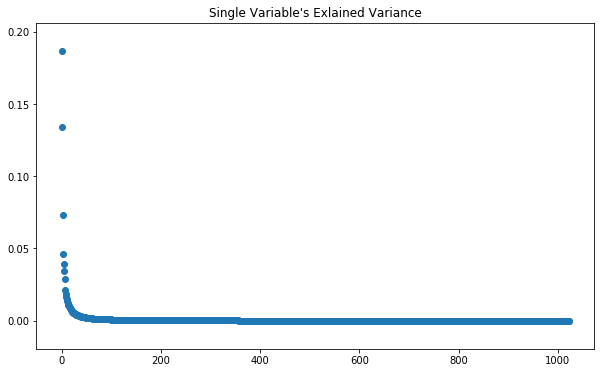

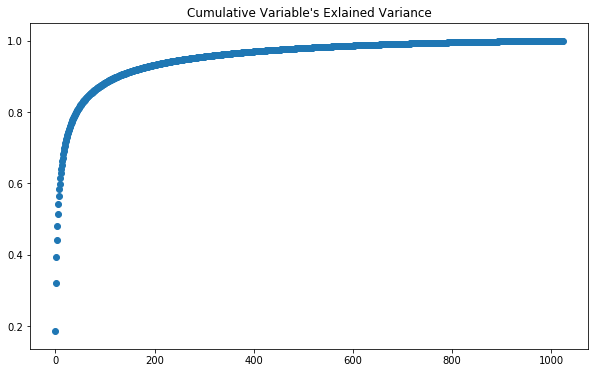

In [0]:
mat = scipy.io.loadmat('COIL100.mat')
X2=mat['fea']
X2=X2/253
true_label=mat['gnd'].flatten()
n=X2.shape[0]
#X2 = StandardScaler().fit_transform(X2)
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
q=min(X2.shape[0],X2.shape[1])
pca = PCA(n_components=q)
principalComponents = pca.fit_transform(X2)

#on peut prendre q=15 0.75% de la variance expliquer et remarque que au dela on ne gagne pas grand chose on ajoutant des composantes

plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_)
plt.title("Single Variable's Exlained Variance")
plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Variable's Exlained Variance")

In [0]:
g=20
q=20
S,Q,Qg,Z,B=algo1_init(X2,q,g)

loss = 
0.2949331510198947
explained variance ratio 
0.5755581189694831
0.1420635624428007


In [0]:
Y=algo1_clustering(S,Z,Q,Qg,X2,B,0.4)

nmi =  0.5755581189694831
ari =  0.1420635624428007
loss =  -2909.630244311081
davies bouldin score =  2.2723004236724265
Silhouette score =  0.10067852417158414


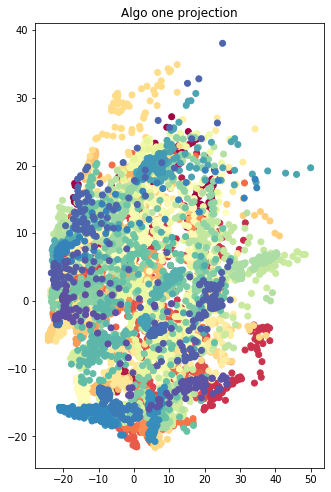

In [0]:
algo1_visualization(Y)

# ORL DATASET

Text(0.5, 1.0, "Cumulative Variable's Exlained Variance")

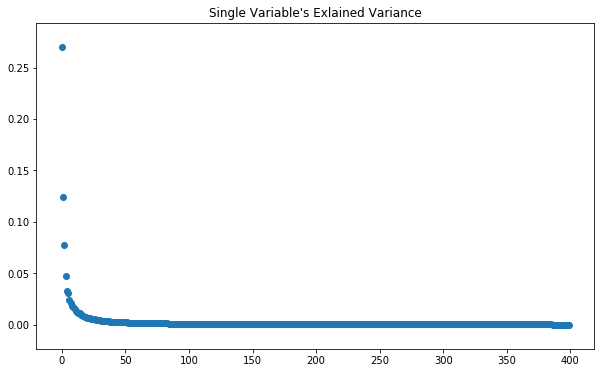

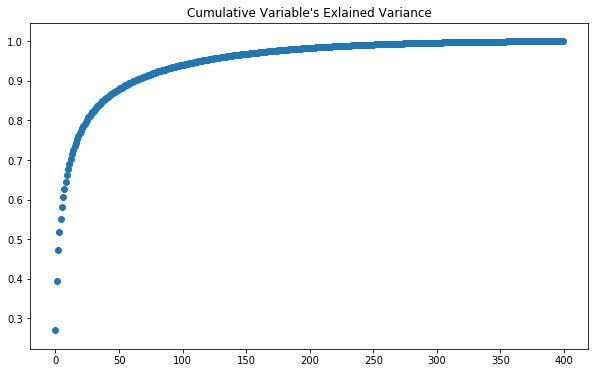

In [0]:
mat = scipy.io.loadmat('ORL.mat')
X2=mat['X']
true_label=mat['Y'].flatten()
n=X2.shape[0]
#X2 = StandardScaler().fit_transform(X2)
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
q=min(X2.shape[0],X2.shape[1])
pca = PCA(n_components=q)
principalComponents = pca.fit_transform(X2)

#on peut prendre q=15 0.75% de la variance expliquer et remarque que au dela on ne gagne pas grand chose on ajoutant des composantes

plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_)
plt.title("Single Variable's Exlained Variance")
plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Variable's Exlained Variance")


In [0]:
g=40
q=20
S,Q,Qg,Z,B=algo1_init(X2,q,g)

loss = 
0.23310132753125917
explained variance ratio 
0.7879333646212254
0.46377778578103473


In [0]:
Y=algo1_clustering(S,Z,Q,Qg,X2,B,0.4)


nmi =  0.7879333646212254
ari =  0.46377778578103473
loss =  467.411396306154
davies bouldin score =  1.7293533117167414
Silhouette score =  0.1557066410509149
nmi =  0.7879333646212254
ari =  0.46377778578103473
loss =  465.05375453444964
davies bouldin score =  1.7293533117167414
Silhouette score =  0.1557066410509149


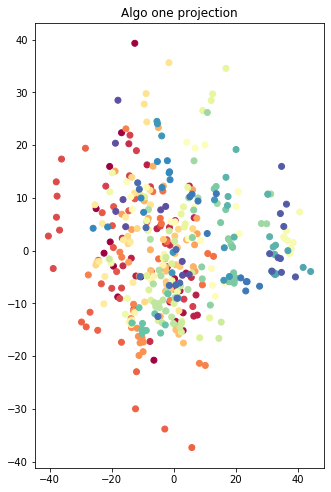

In [0]:
algo1_visualization(Y)

# YALE DATASET

Text(0.5, 1.0, "Cumulative Variable's Exlained Variance")

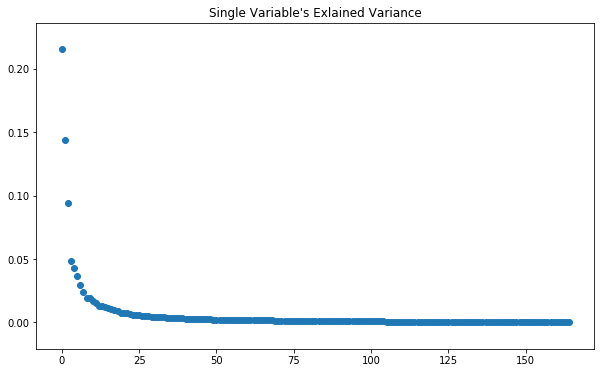

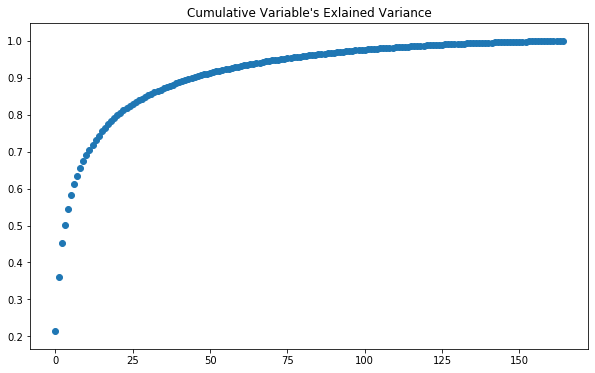

In [0]:
mat = scipy.io.loadmat('Yale.mat')
X2=mat['X']
true_label=mat['Y'].flatten()
n=X2.shape[0]
#X2 = StandardScaler().fit_transform(X2)
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
q=min(X2.shape[0],X2.shape[1])
pca = PCA(n_components=q)
principalComponents = pca.fit_transform(X2)

#on peut prendre q=15 0.75% de la variance expliquer et remarque que au dela on ne gagne pas grand chose on ajoutant des composantes

plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_)
plt.title("Single Variable's Exlained Variance")
plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Variable's Exlained Variance")

In [0]:
g=15
q=20
S,Q,Qg,Z,B=algo1_init(X2,q,g)

loss = 
0.20932444939144654
explained variance ratio 
0.613757442048616
0.38346311683415263


In [0]:
Y=algo1_clustering(S,Z,Q,Qg,X2,B,0.4)

nmi =  0.613757442048616
ari =  0.38346311683415263
loss =  358.27830790150176
davies bouldin score =  1.8966867586463176
Silhouette score =  0.09134171601742934
nmi =  0.613757442048616
ari =  0.38346311683415263
loss =  357.5426681024726
davies bouldin score =  1.8966867586463176
Silhouette score =  0.09134171601742934


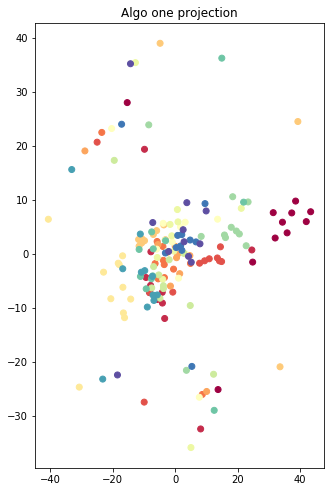

In [0]:
algo1_visualization(Y)

# USPS DATASET

Text(0.5, 1.0, "Cumulative Variable's Exlained Variance")

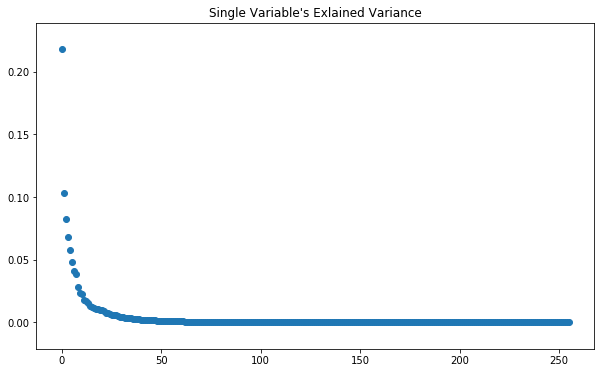

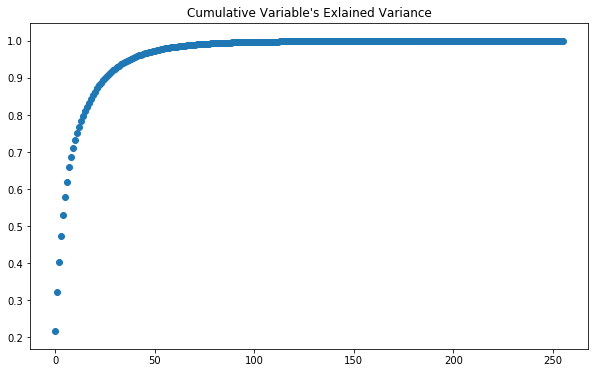

In [0]:
mat = scipy.io.loadmat('USPS.mat')
X2=mat['X']
true_label=mat['y'].flatten()
n=X2.shape[0]
#X2 = StandardScaler().fit_transform(X2)
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
q=min(X2.shape[0],X2.shape[1])
pca = PCA(n_components=q)
principalComponents = pca.fit_transform(X2)

#on peut prendre q=15 0.75% de la variance expliquer et remarque que au dela on ne gagne pas grand chose on ajoutant des composantes

plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_)
plt.title("Single Variable's Exlained Variance")
plt.figure(figsize=(10,6))
plt.scatter(list(range(q)), pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Variable's Exlained Variance")

In [0]:
g=10
q=20
S,Q,Qg,Z,B=algo1_init(X2,q,g)

loss = 
0.14684377144027805
explained variance ratio 
0.5671699681944056
0.47344056300945375


In [0]:
    pred_label=[]
    for i in range(0,Z.shape[0]):
      for j in range(0,Z.shape[1]):
        if(Z[i][j]==1):
          pred_label.append(j)
    nmi=normalized_mutual_info_score(true_label,pred_label)
    ari=adjusted_rand_score(true_label,pred_label)
    print("nmi = ",nmi)
    print("ari = ",ari)
    loss_cur=loss_perso(X2,Q,Z,S,Qg,Beta)
    print("loss = ",loss_cur)
    print("davies bouldin score = ",davies_bouldin_score(X2, pred_label)) 
    print("Silhouette score = ",silhouette_score(X2, pred_label)) 
    Y=np.dot(X2,Q)

nmi =  0.5671699681944056
ari =  0.47344056300945375
loss =  -5849.400756463178
davies bouldin score =  2.0477254539138237
Silhouette score =  0.14307180943104747


In [0]:
Y=algo1_clustering(S,Z,Q,Qg,X2,B,0.4)

nmi =  0.5873671736154898
ari =  0.5038317614309582
loss =  -5849.392401180953
davies bouldin score =  2.0487483707756207
Silhouette score =  0.1431318784303875


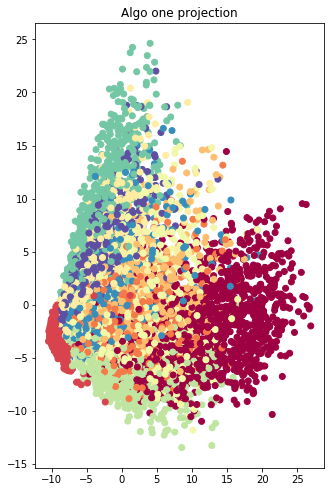

In [0]:
algo1_visualization(Y)